In [3]:
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Fetching Data and Creating Transition Matrix

In [3]:
dataFrame = processData.processingData()
#address is: /home/netlab/Desktop/thesis/data/1node1-3-5/
#/home/netlab/Desktop/thesis/data/500f80271400/
data = dataFrame.copy() #copying the dataFrame to have a copy of not edited data

data = processData.dataFrameManipulation(data)

the address of the collected data files (not alligned files or CSV files): /home/sepehr/thesis/data/500f80271400/
['500f80271400.txt']
here
500f80271400.txt is in csvChecker

we have the csv file: pulling out data

   col1                time  CU
0     0 2018-11-13 02:01:32  45
1     1 2018-11-13 02:01:38  45
2     2 2018-11-13 02:01:44  51
3     3 2018-11-13 02:01:50  53
4     4 2018-11-13 02:01:56  45
now we have the processed data from pandas
please enter how long would be the chunk minutes? 30
removing weekends from the data


In [32]:
x = data.loc[data["day"] == 1]

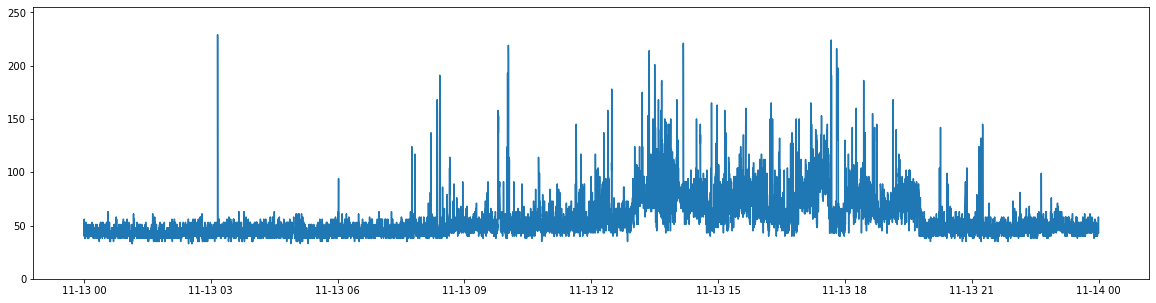

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.ylim(0, 255)
plt.plot(x["time"], x["CU"])

In [5]:
numberOfStates = 255
cuTrans_30min = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans_30min = processData.normalizingTransMatrix(cuTrans_30min)

# Calculating days and shuffling with seed to create Correlations

In [6]:
def dayCalculator(x):
    years = x["time"].year - data["time"][0].year
    months = x["time"].month - data["time"][0].month
    days = x["time"].day - data["time"][0].day
    return ((years*12*30) + (months*30) + days)
data["day"] = data.apply(lambda x: dayCalculator(x), axis = 1)

In [12]:
uniqueDays = []
uniqueDays.extend(data.apply(lambda x: x["day"] if x["day"] not in uniqueDays else np.inf, axis = 1))
uniqueDays = list(set(uniqueDays))
random.Random(0).shuffle(uniqueDays)

days30 = uniqueDays[0:30]
data_within_30Days = data.loc[data["day"].isin(days30)]

In [15]:
numberOfStates = 255
cuTrans_30Days = processData.markovianTransitionMatrixDegree1(data_within_30Days, numberOfStates, "CU")
normalizedCuTrans_30Days = processData.normalizingTransMatrix(cuTrans_30Days)

In [16]:
from scipy import signal
pd.options.mode.chained_assignment = None
steadyState_30days = np.zeros(shape=(normalizedCuTrans_30Days.shape[0],
                                     normalizedCuTrans_30Days.shape[1]))
for i in range(normalizedCuTrans_30Days.shape[0]):
    steadyState_30days[i] = abs(pysal.spatial_dynamics.ergodic.steady_state(normalizedCuTrans_30Days[i]))

# Calculating Correlations

In [20]:
for x in range(48):
    data["corr" + str(x + 1)] = np.inf

In [21]:
print(uniqueDays)
for j in uniqueDays:
    print(j)
    for i in range(48):
        data_correlation = data.loc[(data["timeIndex"] == i) & (data["day"] == j)].copy()
        if len(data_correlation) == 0:
            continue
        cuTran_corr = processData.markovianTransitionMatrixDegree1(data_correlation, numberOfStates, "CU")
        for x in range(cuTran_corr[-1].shape[0]):
            if np.sum(cuTran_corr[-1][x]) == 0:
                continue
            cuTran_corr[-1][x] = cuTran_corr[-1][x] / np.sum(cuTran_corr[-1][x])
        steadyState_corr = abs(pysal.spatial_dynamics.ergodic.steady_state(cuTran_corr[-1]))

        steadyState_corr_normalize = (steadyState_corr - np.mean(steadyState_corr)) / (
            np.std(steadyState_corr) * len(steadyState_corr))
        
        correlationDistance = []
        
        for x in range(48):
            ss_normalize = (steadyState_30days[x] - np.mean(steadyState_30days[x])) / (
                np.std(steadyState_30days[x]))
            data["corr" + str(x + 1)].loc[(data["timeIndex"] == i) & (data["day"] == j)] = signal.correlate(
                steadyState_corr_normalize, ss_normalize, mode="valid")[0]

[31, 10, 15, 9, 185, 17, 1, 252, 257, 195, 22, 205, 191, 167, 238, 2, 184, 246, 224, 210, 25, 8, 32, 14, 201, 147, 30, 146, 240, 161, 254, 236, 177, 264, 245, 141, 153, 219, 178, 18, 243, 216, 4, 28, 21, 29, 148, 223, 198, 211, 218, 189, 215, 35, 260, 183, 259, 0, 217, 154, 199, 253, 3, 258, 197, 251, 36, 164, 196, 250, 247, 202, 168, 11, 239, 163, 24, 225, 212, 149, 237, 16, 244, 160, 23, 208, 37, 222, 182, 203, 162, 190, 204, 209, 150, 7, 192, 188]
31
10
15
9
185
17
1
252
257
195
22
205
191
167
238
2
184
246
224
210
25
8
32
14
201
147
30
146
240
161
254
236
177
264
245
141
153
219
178
18
243
216
4
28
21
29
148
223
198
211
218
189
215
35
260
183
259
0
217
154
199
253
3
258
197
251
36
164
196
250
247
202
168
11
239
163
24
225
212
149
237
16
244
160
23
208
37
222
182
203
162
190
204
209
150
7
192
188


# Creating Staionary Process Values

In [37]:
copy_data = data.copy()
data["logDiff"] = np.inf
data["log"] = np.inf
data["normalLogDiff"] = np.inf

In [38]:
for i in range(np.max(data["timeIndex"])):
    dataTimeIndex = data.loc[data["timeIndex"] == i]
    dataTimeIndex["log"] = np.log(dataTimeIndex["CU"])
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["logDiff"] = dataTimeIndex["log"].diff()
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["normalLogDiff"] = dataTimeIndex["logDiff"] / np.max(dataTimeIndex["logDiff"])
    data.loc[data["timeIndex"] == i] = dataTimeIndex
    
data = data.loc[data["log"] != np.inf]
data = data.loc[data["log"] != -np.inf]
data = data.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

# Writing Feature Engineered DataFrame into a Pickle

In [41]:
data.to_pickle("30min_featureEngineer.pickle")

In [25]:
x = pd.read_pickle("30min_featureEngineer.pickle")

In [27]:
def plottingDataChunks(data):
    intervalMinutes = int(input("how long is your intervals in minute? "))
    timeIndexValue = int(input("which timeInterval in a day you want to plot? "))
    plotDataFrame = data.loc[data["timeIndex"] == timeIndexValue]
    data_CU_to_numpy = plotDataFrame["CU"].to_numpy()
    data_day_to_list = plotDataFrame["weekDay"].to_list()

    day_changes_index = []
    initialDay = data_day_to_list[0]
    for i in range(len(data_day_to_list)):
        if initialDay != data_day_to_list[i]:
            day_changes_index.append(i)
            initialDay = data_day_to_list[i]

    dividerBoundary = [-1,0,0,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,0,0,-2]
    for j in range(25 - 1, 0, -1):
        data_CU_to_numpy = np.insert(data_CU_to_numpy, day_changes_index[j], dividerBoundary)

    scatterArray = []
    fig = go.Figure()
    prevPos = 0
    for i in range(data_CU_to_numpy.shape[0]):
        if data_CU_to_numpy[i] == -1:
            timePlot = [x for x in range(prevPos, i - 1)]
            scatterArray.append(go.Scatter(x = timePlot, y = data_CU_to_numpy[prevPos: i-1], marker_color='blue'))

        if data_CU_to_numpy[i] == -2:
            timePlot = [x for x in range(i - len(dividerBoundary) + 1, i + 1)]
            scatterArray.append(go.Scatter(x = timePlot, y = data_CU_to_numpy[i - len(dividerBoundary) + 1: i + 1], marker_color='red'))
            prevPos = i + 1

    fileName = str(intervalMinutes) + "minInterval" + str(timeIndexValue) + "th.html"
    offline.plot(scatterArray, filename=fileName, image="svg")
    
    
plottingDataChunks(x)

how long is your intervals in minute? 30
which timeInterval in a day you want to plot? 30


In [18]:
qqq = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]

In [21]:
len(qqq)*5

595

In [4]:
data = pd.read_pickle("30min_featureEngineer.pickle")

In [5]:
numberOfStates = 255
cuTrans = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

In [6]:
def preparingMatrixForLumping(transitionMatrix):
    reload(oldLumping)
    percentageMatrix_list = bandwidthPercentage(transitionMatrix)
    zero_cols_rows = []
    #*************removing zeros from columns and rows (matrix reduction) ****************
    for i in range(len(transitionMatrix)):
        if (np.sum(transitionMatrix[i]) == 0) and (np.sum(transitionMatrix[:,i]) == 0):
            zero_cols_rows.append(i)


    irreducible_matrix = transitionMatrix.copy()
    for i in range(len(zero_cols_rows) - 1, -1, -1):
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 0)
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 1)
        percentageMatrix_list[zero_cols_rows[i]][2] = True


    for i in range(len(percentageMatrix_list) - 1, 0, -1):
        if (percentageMatrix_list[i][2] == True) and (percentageMatrix_list[i - 1][2] == True):
            percentageMatrix_list[i - 1][0].extend(percentageMatrix_list[i][0])
            percentageMatrix_list[i - 1][1] = percentageMatrix_list[i][1]
            del percentageMatrix_list[i]

    for i in range(len(irreducible_matrix)):
        if np.sum(irreducible_matrix[i], dtype = np.float32) != 1.0:
            print(np.sum(irreducible_matrix[i], dtype = np.float32))

    return percentageMatrix_list, irreducible_matrix

def bandwidthPercentage(vectorMatrix):
    percentageIncreament = (100 / vectorMatrix.shape[0])
    percentageMatrix = []
    maxPercentage = 0
    for j in range(vectorMatrix.shape[0]):
        maxPercentage += percentageIncreament
        percentageMatrix.append([[j], maxPercentage, False])

    return percentageMatrix

In [11]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [8]:
for i in range(len(normalizedCuTrans)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/8normal_lumping_15_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/8normal_lumping_15_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
hello
we have these many sectors to check:  343419
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
hello
we have these many sectors to check:  230135
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
hello
we have these many sectors to check:  35423
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
hello
we have these many sectors to check:  45275
1.0000001
0.99999994
0.9999999
0.99999994
1.0000001
1.0000001
hello
we have these many sectors to check:  106611
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
0.9999999
0.99999994
0.99999994
0.99999994
hello
we have these many sectors to check:  76135
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
hello
we have these many sectors to check:  46965
0.99999994
1.0000001
hello
we have these many sectors to check:  13980
0.99999994
1.0000001
0.9999999
1.0000001
hello
we have these many sectors to check:  35488
0.99999994
0

In [9]:
data = pd.read_pickle("5minMerged_featureEngineer.pickle")

In [10]:
numberOfStates = 255
cuTrans = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

In [12]:
for i in range(len(normalizedCuTrans)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/8merged_lumping_35_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/8merged_lumping_35_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

1.0000001
0.99999994
0.99999994
0.9999999
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
hello
we have these many sectors to check:  643336
0.99999994
1.0000001
0.99999994
1.0000001
1.0000001
1.0000001
hello
we have these many sectors to check:  484006
0.99999994
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
1.0000001
1.0000001
1.0000001
hello
we have these many sectors to check:  450815
0.99999994
1.0000001
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
hello
we have these many sectors to check:  577997
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
hello
we have these many sectors to check:  629968
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
hello
we have these many sectors to check:  656737
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
1.0000